# Grover's Algorithm on 1-IN-3-SAT

So far, we've been focusing on fairly simple systems designed solely for observing and understanding mysterious behavior in quantum mechanics. Now, we'll put our engineering hats on and build a circuit that will actually solve a real (albeit small scale) problem. Although the problem we'll tackle is small, it is by no means easy. In fact, let's go straight for some of the hardest (yet most important) types of problems studied, a $\mathcal{NP}$-complete problem!

<span style="color: red;">
First, here’s a quick recap on complexity theory, so we can really appreciate what we’re about to do.
  
Algorithms can be compared in terms of how much space (memory) or time (number of operations) they require, in terms of their input size (denoted N). This is also called big O notation. We can take this a step further by considering the types of problems that these algorithms solve – these are separated into sets.

We have our first set, P (polynomial time), which represents all of the problems that can be solved efficiently by a computer. “Efficiently” means that the time taken to solve the problem grows at most as a polynomial function of the input size (e.g. N^2, N^3, etc). For example, sorting a list of numbers can be done in O(NlogN). You can think of these problems as problems that we can always solve in a reasonable amount of time on a classical computer – no matter how many inputs our problem has. Taking our example, no matter how big our list is, we will be able to sort the list in a human-scale timeframe – it might take a couple of days, but at least it won’t take until the heat death of the universe.
However, there are problems that, with our current best algorithms, scale faster than polynomial time—these problems seem to require super-polynomial or exponential time to solve as input size grows. This means that as N increases, the time required to solve these problems grows so quickly that for large inputs, solving them becomes practically impossible.

These problems belong to a larger complexity class called NP (Nondeterministic Polynomial time). More specifically, this class is for problems where a given solution can be verified efficiently (in polynomial time), even if finding the solution might be hard (where “hard” solutions are solutions that take longer than polynomial time to solve). One example of this is factoring a number – for numbers with hundreds of digits, there are so many possible potential factors, that it is really time-consuming to check every single one of them. Checking that a number is a factor of a number though is easy? You just divide them and see if there is a remainder or not. NP problems can be efficiently verified, but (as of right now) not efficiently solved.

The central question in computer science is whether every problem whose solution can be verified quickly (NP) can also be solved quickly (P). In other words, is P = NP, or is P strictly smaller than NP (meaning there are problems that are easy to check but fundamentally hard to solve)?
If P equals NP, then every problem in NP can actually be solved efficiently, and many currently intractable problems (like breaking cryptographic encryption, perfect scheduling, and protein folding) would suddenly become feasible. If P does not NP, then there are problems that are inherently hard to solve, no matter how clever our algorithms get.

An interesting approach to proving P=NP is by focusing on the NP-complete subset of the NP complexity class. NP-complete problems have two defining characteristics:

1.	**They are in NP** – Their solutions can be verified in polynomial time.
2.	**They are NP-hard** – Every problem in NP can be transformed (reduced) into them in polynomial time. This means that if we can solve one NP-complete problem efficiently, we can efficiently solve every problem in NP (put another way, we can translate, in polynomial time, a solution from one problem into a solution for the other problem). To prove a problem is NP-complete, we take an existing NP-complete problem and show that it can be reduced to our problem in polynomial time.

The key idea is that if we find a polynomial-time solution to just one NP-complete problem, then, using polynomial-time reductions, we can efficiently transform this solution into solutions for all NP problems. Since the composition of two polynomial-time algorithms is still a polynomial-time algorithm, this would imply that every NP problem has an efficient solution, proving that P=NP.

Now, we just need to solve an NP-complete problem! One famous example of an NP-complete problem is the Boolean Satisfiability Problem – the problem we are going to try to solve on a quantum computer today! More specifically, we are going to solve a variation of the Boolean Satisfiability Problem – the 1-In-3 SAT Problem. We’ll get into more formally how the 1-IN-3 SAT problem is defined, but let’s go over what a satisfiable problem is first.

However, what exactly does it mean for an expression to be satisfiable? "Satisfiability" of Boolean expressions refers to figuring out if there is a way to assign values of True (1) or False (0) to the variables in a Boolean expression such that the entire expression becomes True (1).</font>

Let's take the following sentence as an example: The object is black AND the object is spherical.

Now, there are different objects we can have that will make this sentence true or false. For example, if we have a black cube, our sentence would evaluate to False (while our object IS black, it is not spherical).

However, if we have a black sphere as our object, our sentence would be true. Our object would be black and our object is spherical. Since our ob
ject meets the criteria for both of our sub-sentences, our entire statement is true - we have satisfied our sentence.

We can turn our sentence into a boolean expression.

$C = x_0 \wedge x_1$, where $x_0$ is 1 if the object is black and $x_1$ is 1 if the object is spherical.

for a black sphere:
C = 1 ^ 1
  = 1

for a black cube:
C = 1 ^ 0
  = 0

Our satifiability problem is to find some sort of object (some assignment of $x_0$ and $x_1$) that makes C true. </span>

In [107]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit.primitives import StatevectorSampler
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

## Quantum Boolean Logic 

Let's get an idea of boolean logic with quantum circuits.

There are two interesting properties of quantum circuits to consider: reversibility and no cloning. Remember that all the quantum circuits (up to measurement) are in theory fully reversible. Additionally, the no-cloning theorem tells us that given a qubit in some unknown state, there's no way to duplicate the state on another qubit.

These two properties require us to use separate input and output registers (qubits), and to be careful about undoing any operations that change our input qubits for future operations. Additionally, we will employ auxiliary qubits, or "ancilla," that will store intermediate values during computation. Just as we have to be hygenic about our input register, we will have to undo our operations on the ancilla to keep their state consistent (also referred to as keeping them "clean").

With this formalism, there are a handful of common logic gates that are particularly easy to implement: `NOT`, `XOR`, and `AND`. This small set of gates is already complete, which means we can build any boolean logic circuit with these gates alone. The three functions below implement classical `AND`, `NOT`, `XOR` gates in a quantum circuit (`circ`) given the input (`a`,`b`) and output (`y`) quantum registers.

In [108]:
def AND(circ,out,a,b): # using a Toffoli gate
    circ.ccx(a,b,out)
def NOT(circ,y): # using an X gate (same output register as input)
    circ.x(y)
def XOR(circ,out,*inputs): # using 2 CNOT gates
    for i in inputs:
        circ.cx(i,out)

def init_superposition(circ, fin): # initialize our input states as equal superpositions, so we test all boolean inputs
    circ.h(fin)

As an example we can implement the expression $V$:

$$V = (x_2 \oplus x_1 \oplus x_0) \wedge \lnot x_2 $$

where the $x_i$s are boolean variables, $\oplus$ is the exclusive "or" (`XOR`) operation, $\lnot$ is the `NOT` operator, and $\wedge$ is the `AND` operator.

A quick calculation tells us $V$ is 1 (True) if and only if $x_2x_1x_0 \in \{ 001, 010 \}$. This is shown in the truth table below.

| $x_0$ | $x_1$ | $x_2$ | $\lnot x_2$ | $x_2 \oplus x_1$ | $x_2 \oplus x_1 \oplus x_0$ | $(x_2 \oplus x_1 \oplus x_0) \wedge \lnot x_2$ | $x_2x_1x_0$ |
|----|----|----|-----------|-----------|------------------|-------------------------------|--------|
| 0  | 0  | 0  | 1         | 0         | 0                | 0                             | 000    |
| 0  | 0  | 1  | 0         | 1         | 1                | 0                             | 100    |
| 0  | 1  | 0  | 1         | 1         | 1                | 1                             | 010    |
| 0  | 1  | 1  | 0         | 0         | 0                | 0                             | 110    |
| 1  | 0  | 0  | 1         | 0         | 1                | 1                             | 001    |
| 1  | 0  | 1  | 0         | 1         | 0                | 0                             | 101    |
| 1  | 1  | 0  | 1         | 1         | 0                | 0                             | 011    |
| 1  | 1  | 1  | 0         | 0         | 1                | 0                             | 111    |

So let's confirm this by simulating the eqivalent quantum circuit using qiskit.

Note: The vertical dashed-lines in the circuit below represents barriers. These aren't gate - they just help make the circuit more readable.

In [109]:
f_in = QuantumRegister(3, 'in')
f_out = QuantumRegister(1, 'out')
aux = QuantumRegister(1, 'aux')
qc = QuantumCircuit(f_in, f_out, aux)
init_superposition(qc, f_in)

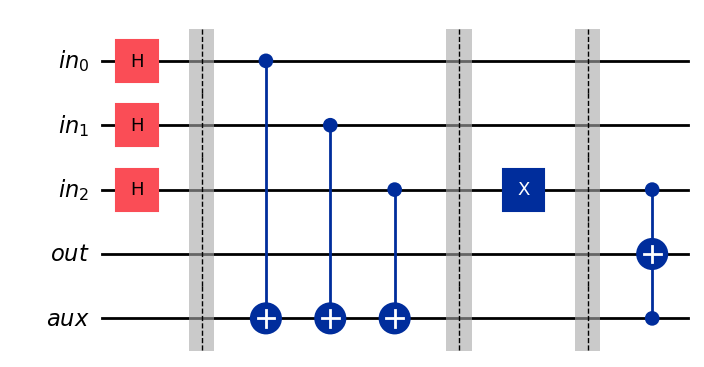

In [110]:
qc.barrier()
XOR(qc, aux[0], f_in[0], f_in[1], f_in[2])
qc.barrier()
NOT(qc, f_in[2])
qc.barrier()
AND(qc, f_out[0], aux[0], f_in[2])
fig = qc.draw("mpl")

After applying all these gates, we will measure all of our qubits (including the ancilla).

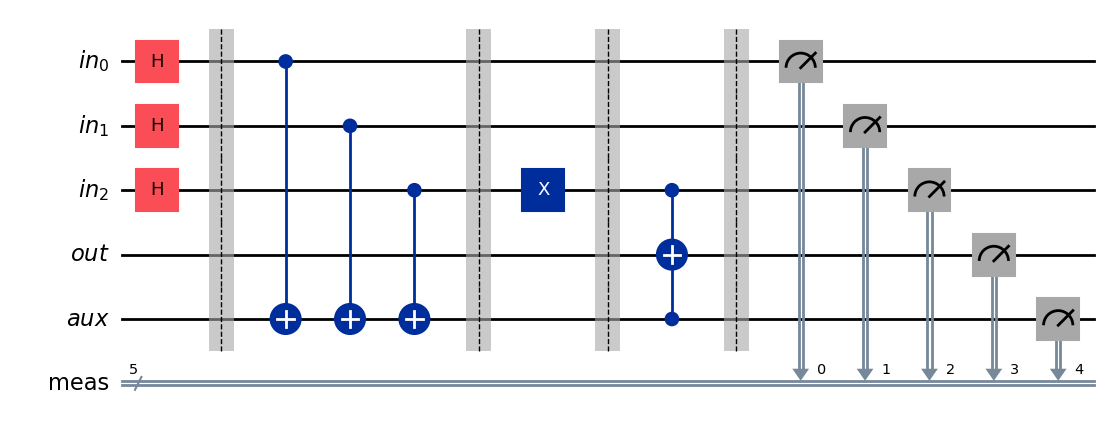

In [111]:
qc.measure_all()
fig = qc.draw(output='mpl')

Don't worry about `qiskit` having apparently moved some of the measurement operations before applying some of our gates. `qiskit` is just optimizing to measure each qubit as soon as possible to make our overall state space as small as possible, which will make the simulation more efficient. These optimizations will not change anything about the outcomes. Now we can simulate our circuit with 1024 trials using the `StatevectorSampler`.

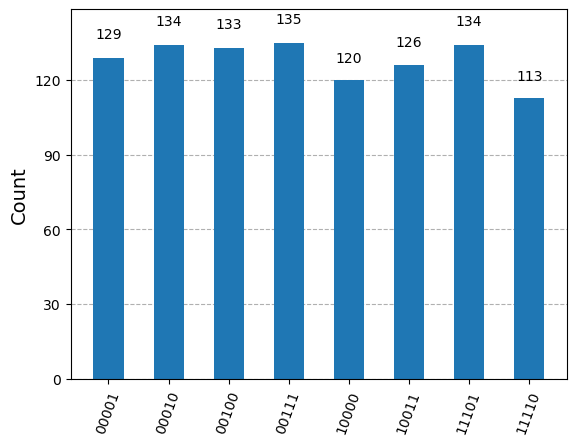

In [112]:
sampler = StatevectorSampler()
result = sampler.run([qc]).result()
#print(result)
#print(result[0])
#print(result[0].data)
data = result[0].data
#print(result[0].data.meas)
counts = data.meas.get_counts()
#print(counts)
fig = plot_histogram(counts)

In [113]:
sorted_counts = []

for count in counts:
    sorted_counts.append(count[2:] + count[0] + count[1])

sorted_counts.sort()

print('f_in | aux | f_out')
for count in sorted_counts:
    print(count[:3] + "  |  " + count[3] + "  |   " + count[4])

f_in | aux | f_out
000  |  1  |   0
001  |  0  |   0
010  |  0  |   0
011  |  1  |   0
100  |  0  |   0
101  |  1  |   1
110  |  1  |   1
111  |  0  |   0


In this case we are less interested in how often we get each result, and more interested in what results we get. You'll notice that there are spaces in between the binary outcomes for each bit to separate each of the registers we defined. Given the order we defined our gates, the first group of three values correspond to our input bits (`f_in`), the second number corresponds to the ancilla (`aux`), and the final number to the output bit (`f_out`). The input bits are printed in decending order ($x_2$, $x_1$, and then $x_0$).

However, you will notice there are two problems: first our ancilla are not always 0 (which means they are no longer clean), and secondly, perhaps more alarmingly, we don't get the correct results. Based on the simulator our expression evaluates to true when for inputs of 101 and 110. Both issues actually have the same cause: we didn't undo our operations.

Try rebuilding the circuit, but now, adding some gates after we write our result to the output qubit.

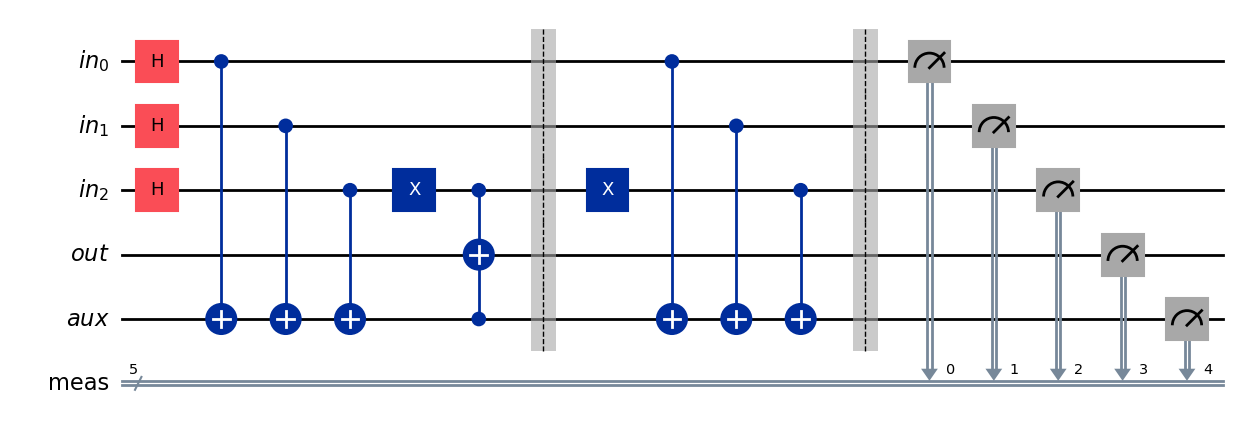

In [114]:
f_in = QuantumRegister(3, 'in')
f_out = QuantumRegister(1, 'out')
aux = QuantumRegister(1, 'aux')
qc = QuantumCircuit(f_in, f_out, aux)
init_superposition(qc, f_in)

XOR(qc, aux[0], f_in[0], f_in[1], f_in[2]) # line 1
NOT(qc, f_in[2]) # line 2
AND(qc, f_out[0], aux[0], f_in[2])
qc.barrier()

# Undo operations to input qubits and ancilla
NOT(qc, f_in[2]) # line 2
XOR(qc, aux[0], f_in[0], f_in[1], f_in[2]) # line 1

qc.measure_all()

fig = qc.draw(output='mpl')

DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=5>))


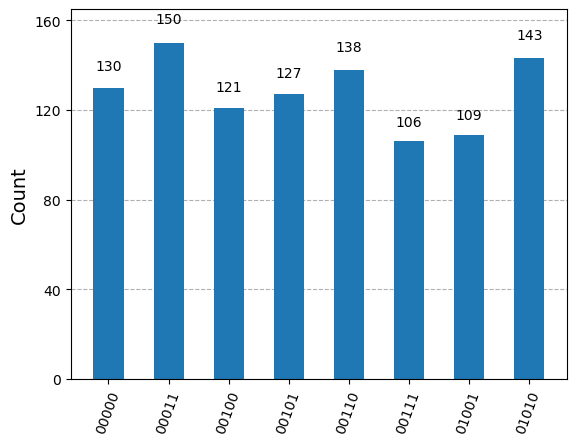

In [115]:
sampler = StatevectorSampler()
result = sampler.run([qc]).result()
data = result[0].data
print(result[0].data)
counts = data.meas.get_counts()
fig = plot_histogram(counts)

In [116]:
sorted_counts = []

for count in counts:
    sorted_counts.append(count[2:] + count[0] + count[1])

sorted_counts.sort()

print('f_in | aux | f_out')
for count in sorted_counts:
    print(count[:3] + "  |  " + count[3] + "  |   " + count[4])

f_in | aux | f_out
000  |  0  |   0
001  |  0  |   1
010  |  0  |   1
011  |  0  |   0
100  |  0  |   0
101  |  0  |   0
110  |  0  |   0
111  |  0  |   0


Note that now our ancilla is always 0, and we can recover the correct results.

The lesson here is that if want to compute an arbitrary function using a quantum circuit, we must use a separate input and output register, in addition to some number of ancilla (theoretically you only ever need a single ancilla qubit, but often the circuit can be greatly simplified by using multiple ancilla). After completing the computation of the function (meaning all necessary gates are applied to the output qubits), we have to undo the computation, by reapplying all the gates (except those that write the results to the output qubits) in reverse order.

### Problem 1: An and and and

In this problem, we are going to implement the simple boolean expression $W$ and check what values satisfy $W$ (which inputs $x_0$, $x_1$, and $x_2$ evaluate to $W$ = 1).

$$ W = x_2 \wedge \lnot x_1 \wedge x_0 $$

Step 1: Identify the inputs for which $W$ = 1 (True). Write this out as a truth table. You will do this by hand.

Step 2: Implement the boolean expression $W$ using Qiskit.

Step 3: Confirm this by simulating the equivilant quantum circuit using Qiskit. Just like in the example, you will need to simulate your circuit multiple times to get all of the different inputs.

Hint 1: You should not need more than one ancilla in your circuit.

Hint 2: Remember to undo your computation to keep your input qubits and ancilla nice and clean. Your ancilla should always come out to zero, and the output should only be true when $x_2x_1x_0 = 101$.

[Your answer here]

## 1-IN-3-SAT

Satisfying boolean expression is a rather important problem in engineering. One especially interesting application is where variables correspond to decisions and the expression might encode constraints or consequences of choices. The goal is to find an assignment of all the variables that will complete, or satisfy, the overall problem. Unfortunately, SAT, and the related 3-SAT problems are $\mathcal{NP}$-complete, so there might not exist an efficient algorithm for finding assignments to the variables which will satisfy the expression.

<font color='red'>
The 3-SAT problem is a specific type of Boolean satisfiability problem (SAT problem) where the Boolean expression is written in a particular form known as Conjunctive Normal Form (CNF). In CNF, the expression is made up of a series of clauses, and each clause is a disjunction (OR) of exactly three literals (variables or their negations). </font>
<font color='red'>
In other words, we have a set of three statements of variables (also called clauses), with the variables inside each statement being combined with OR gates - importantly, there must be three, and only three, variables in each of these clauses. Additionally, each of these three clauses are combined with AND gates. </font>

Just like 3-SAT, our subject, 1-IN-3-SAT, starts with a boolean expression comprising of some number of clauses using $N$ boolean variables ($x_i \in \left\{ 0,1 \right\}$). 

Let $E$ be our input expression made up of $M$ clauses, where $c_j$ is the $j$th clause, then,

$$ E = c_0 \wedge c_1 \wedge \ldots \wedge c_{M-2} \wedge c_{M-1} $$

Each clause $c_j$ is a disjunction of three variables (possibly negated). For example, $c_1$ might contain $x_0$, $x_1$, and $x_2$, so that

$$ c_1 = x_0 \vee \lnot x_1 \vee x_2 $$

where $\lnot$ is the `NOT` operator, $\wedge$ is the `AND` operator, and $\vee$ is the `OR` operator.

Given expression $E$, containing $N$ variables, we have to find the assignments of the variables ($x_i$) which will satisfy  $E$. However, so far, this is just the 3-SAT problem. There's the additional twist that, in each of our clauses $c_j$, exactly one of the terms is true, while the other two must be false. These additional constraints can be encoded by transforming our example clause $c_1$ to $g_1$:

$$ g_1 = x_0 \oplus \lnot x_1 \oplus x_2 \oplus ( x_0 \wedge \lnot x_1 \wedge x_2 )$$
<font color='red'>
Now $g_1$ will be true only if $x_0$ or $\lnot x_1$ or $x_2$ is true.</font>

Therefore, the problem in 1-IN-3-SAT is, given an expression $E$ to find assignments to our variables $x_i$ to satisfy the transformed expression $E'$:

$$ E' = g_0 \wedge g_1 \wedge \ldots \wedge g_{M-2} \wedge g_{M-1} $$

where each clause $g_j$ is the result of transforming $c_j$ as described above.

Note that our transformed clauses include only `NOT`, `AND`, and `XOR` operations, which makes this problem relatively easy to implement using common quantum gates.

Below is a function that takes in an expression $E$ and implements the corresponding $E'$ on circuit `circ` to be used in Grover's algorithm.

The expression (`expression`) that is passed in to the function must be a `list` of clauses (we'll limit ourselves to 3 clause expressions). Each clause is a list of terms in the form of integers. The value of each integer refers to the variable index, and the sign to whether or not the variable is negated.

For example, if:

$$ E = (x_0 \vee x_1 \vee \lnot x_2) \wedge (\lnot x_0 \vee \lnot x_1 \vee \lnot x_2) \wedge (\lnot x_0 \vee x_1 \vee x_2) $$

Then the corresponding expression becomes `expression = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]`. 

Here $i+1$ corresponds to $x_i$ and $-(i+1)$ corresponds to $NOT(x_i)$, where $i=0, 1, 2$. We have changed $x_i$ to $i+1$ only for programming convenience (see program below).


The answer to this expression is $x_0 = 1, x_1 = 0, x_2 = 1$, satisfy the 1-IN-3-SAT requirement. 

$$ => E = (1 \vee 0 \vee \lnot 1) \wedge (\lnot 1 \vee \lnot 0 \vee \lnot 1) \wedge (\lnot 1 \vee 0 \vee 1) $$
$$ E = (1 \vee 0 \vee 0) \wedge (0 \vee 1 \vee 0) \wedge (0 \vee 0 \vee 1) $$

## Grover's Algorithm

So far when we simulated our logic expressions, we ran many trials to get an estimate of all the possible outcomes, and then we could infer which assignments of the variables would produce an output of 1. However, if our expression is large, and comprises of many variables, then it may take exponentially (in the number of variables) many trials before we will observe a satisfying assignment (ie. the output is measured to be 1). 

Consequently, we want to increase the probability of measuring our output qubit to be 1. Grover's algorithm is an iterative algorithm which will do just that. In each step of Grover's algorithm, we first evaluate the input expression from a superposition of all possible states invert only those states we are interested in (this called applying the "oracle" operator), and then we will invert the amplitudes about the mean, which will increase the probability of measuring the desired outcome.

The `apply_oracle` function takes care of the first step, and below the function `invert_about_avg` executes the second step.

In [120]:
def apply_oracle(circ, f_in, f_out, aux, n, expression):
    num_clauses = len(expression)
    for (k, clause) in enumerate(expression):
        # This loop ensures aux[k] is 1 if an odd number of literals are true
        for literal in clause:
            if literal > 0:
                circ.cx(f_in[literal-1], aux[k])
            else:
                circ.x(f_in[-literal-1])
                circ.cx(f_in[-literal-1], aux[k])
            
        # Flip aux[k] if all literals are true, using auxiliary qubit (ancilla) aux[num_clauses]
        circ.barrier(f_in)
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        circ.ccx(f_in[2], aux[num_clauses], aux[k])
        circ.barrier(f_in)
        
        # Flip back to reverse state of negative literals and ancilla
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circ.x(f_in[-literal-1])
        circ.barrier()
        
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circ.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circ.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circ.ccx(aux[0], aux[1], aux[num_clauses])
        circ.ccx(aux[2], aux[num_clauses], f_out[0])
        circ.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    circ.barrier()
    
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(expression):
        for literal in clause:
            if literal > 0:
                circ.cx(f_in[literal-1], aux[k])
            else:
                circ.x(f_in[-literal-1])
                circ.cx(f_in[-literal-1], aux[k])
        circ.barrier(f_in)
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        circ.ccx(f_in[2], aux[num_clauses], aux[k])
        circ.barrier(f_in)
        circ.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circ.x(f_in[-literal-1])
        circ.barrier()

In [121]:
def CnX(circ, ctrls, target, clean_aux=None):
    assert len(ctrls) >= 1, 'No control qubits specified'
    if not isinstance(ctrls, list):
        ctrls = tuple(ctrls)
    if len(ctrls) == 1:
        try:
            circ.cx(ctrls[0], target[0])
        except:
            circ.cx(ctrls[0], target)
    elif len(ctrls) == 2:
        try:
            circ.ccx(ctrls[0], ctrls[1], target[0])
        except:
            circ.ccx(ctrls[0], ctrls[1], target)
    else:
        aux = clean_aux
        if aux is None or len(aux) != len(ctrls)-2:
            print('Did not receive the right number of ancillae - automatically creating new ones: got {}, need {}'.format(len(aux),len(ctrls)-2))
            aux = QuantumRegister(len(ctrls)-2, 'aux')
            circ.add_register(aux)
            aux = list(aux)
        if not isinstance(aux, list):
            aux = list(aux)
        a,b,y = ctrls.pop(), ctrls.pop(), aux.pop()
        circ.ccx(a,b,y)
        ctrls.append(y)
        CnX(circ, ctrls, target, aux)
        circ.ccx(a,b,y)

def CnZ(circ, ctrls, target, clean_aux=None):
    circ.h(target)
    CnX(circ, ctrls, target, clean_aux)
    circ.h(target)
        
def invert_about_avg(circ, bits, aux=None):
    try:
        bits[1:]
        gbits = bits
    except:
        gbits = tuple(bits)
    circ.h(bits)
    circ.x(bits)
    circ.barrier(bits)
    CnZ(circ, gbits[:-1], gbits[-1], aux)
    circ.barrier(bits)
    circ.x(bits)
    circ.h(bits)
    
def init_grover(circ, fin, fout):
    circ.h(fin)
    circ.x(fout)
    circ.h(fout)

Let us first understand each step of this circuit of Grover's algorithm. The example circuit below has 3 input qubits $(x_0, x_1, x_2)$ and one clause in expression. The output qubit is $out_0$, the aux qubits (extra bits to help with computation) are $aux_0, aux_1$. We will only perform one iteration of Grover's algorithm on this example. 

Remember that $x_0, x_1, x_2, out_0, aux_0, aux_1$ are all zeros at the begining. 

With `expression = [[1, 2, -3]]`, we have expression: 
$$ E = c_1 = x_0 \vee x_1 \vee \lnot x_2 $$
Then we have 1-IN-3-SAT transformed expression: 
$$ E' = g_1 = x_0 \oplus x_1 \oplus \lnot x_2 \oplus ( x_0 \wedge x_1 \wedge \lnot x_2 )$$

In [122]:
# In the code below x0, x1, x2 are represented by [1, 2, 3]
n = 3
expression = [[1, 2, -3]]

f_in = QuantumRegister(n, 'x')
f_out = QuantumRegister(1, 'out')
aux = QuantumRegister(len(expression) + 1, 'aux') # our oracle requires n+1 ancilla

grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)

XOR(grover, f_out, [f_in[0], f_in[1]])
invert_about_avg(grover, f_in, aux)

fig = grover.draw()

The following steps corresponding to each block (separate by long gray vertical bars) in the circuit diagram above:

1. Initialize the input qubits and output qubit of Grover's algorithm
2. Apply $\hat{V}$ (oracle reflection transformation) with 1st clause of expression to the input qubits. (Creating transformed expression $E'$) The following small steps are separated by short gray vertical bars.
    1. $ aux_0 = x_0 \oplus x_1 \oplus \lnot x_2 $
    2. $ < aux_1 = x_0 \wedge x_1 > $  
        $ < aux_0 = aux_1 \wedge x_2 = x_0 \wedge x_1 \wedge x_2 > $   
        Now we obtain the $g_1$ clause on $aux_0$:
        $ aux_0 = aux_0 \oplus (x_0 \wedge x_1 \wedge x_2) = x_0 \oplus x_1 \oplus \lnot x_2 \oplus (x_0 \wedge x_1 \wedge x_2) $  
    3. The last two gates will flip back the input qubits $(x_0, x_1, x_2)$ and aux qubit $(aux_1)$ to make sure state is consistent. (control qubit don't need to flip back).  
`FYI, there will be 2nd, 3rd, ... clauses if we have to do them.`
    
3. Apply the result to the output qubit   
  $ out_0 = out_0 \oplus aux_0 $
4. Flip back all the qubits except $out_0$. Apply the exact same gates as step 2.
5. Apply $\hat{W}$ (invert and average transformation) to the input qubits. See detail about this transformation at Example 6.5.7.8 in Chap 6 Lecture note (Page 47-48).

Below is a PDF of a detailed explanation of the V-gate.

In [1]:
from IPython.display import IFrame
pdf_path = "./Notebook 5 - Grovers Algorithm V-Gate Explanation.pdf"
IFrame(pdf_path, width="800", height="600")

Now we can put all the steps together and build the circuit that applies Grover's algorithm to the desired expression to solve the 1-IN-3-SAT problem.  
The example circuit below has 3 input qubits $(x_0, x_1, x_2)$ and three clauses in expression. The output qubit is $out_0$, the aux qubits (extra bits to help with computation) are $aux_0, aux_1$. We will only perform one iteration of Grover's algorithm on this example. 

In [125]:
n = 3
expression = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

f_in = QuantumRegister(n, 'x')
f_out = QuantumRegister(1, 'out')
aux = QuantumRegister(len(expression) + 1, 'aux') # our oracle requires n+1 ancilla

grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)

Since Grover's algorithm is iterative we can choose how many steps to take before measuring. It turns out, that we actually have to be careful not to take too many steps, which will cause overrotation, which means our desired outcomes actually become less likely again.

In [126]:
T = 2 # number of steps to take

init_grover(grover, f_in, f_out)
for t in range(T):
    grover.barrier()
    apply_oracle(grover, f_in, f_out, aux, n, expression)
    invert_about_avg(grover, f_in, aux)

In [127]:
grover.measure_all()

Now we can simulate our circuit, and run many trials to get an idea of how likely each outcome is. This is a fairly large circuit, so don't worry if the simulator needs a couple seconds.

DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=8>))


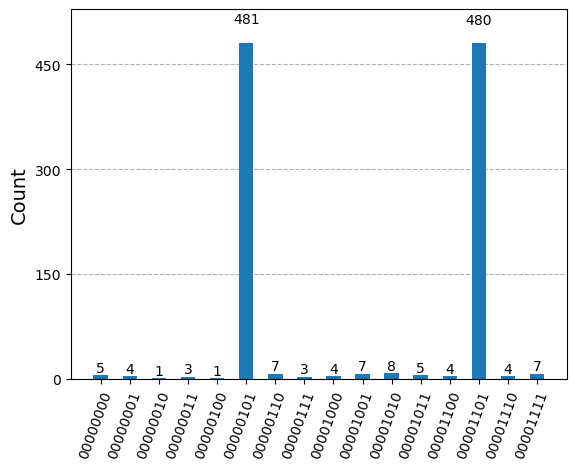

In [128]:
sampler = StatevectorSampler()
result = sampler.run([grover]).result()
data = result[0].data
print(result[0].data)
counts = data.meas.get_counts()
fig = plot_histogram(counts)

As you can see, we measure the outcome 101 most than of the time. The corresponding assignment does in fact satisfy the expression just like we wanted.

We can also see just how large our circuit actually is. Considering we have to apply our oracle gate once for each step, all the while making sure to keep our ancilla and input clean, you might not be surprised how large our gate can get.

The number of times of times the algorithm has to be applied to find a solution is sqrt(N/M), where N is total possible (000 - 111) and M is the number of satifying solutions.

In this case, \
N = 2^3 <- 8 possible solutions \
M = 2 <- the number of satifying solutions \
sqrt(2^3/2) = sqrt(8/2) = sqrt(4) = 2 steps for the best results

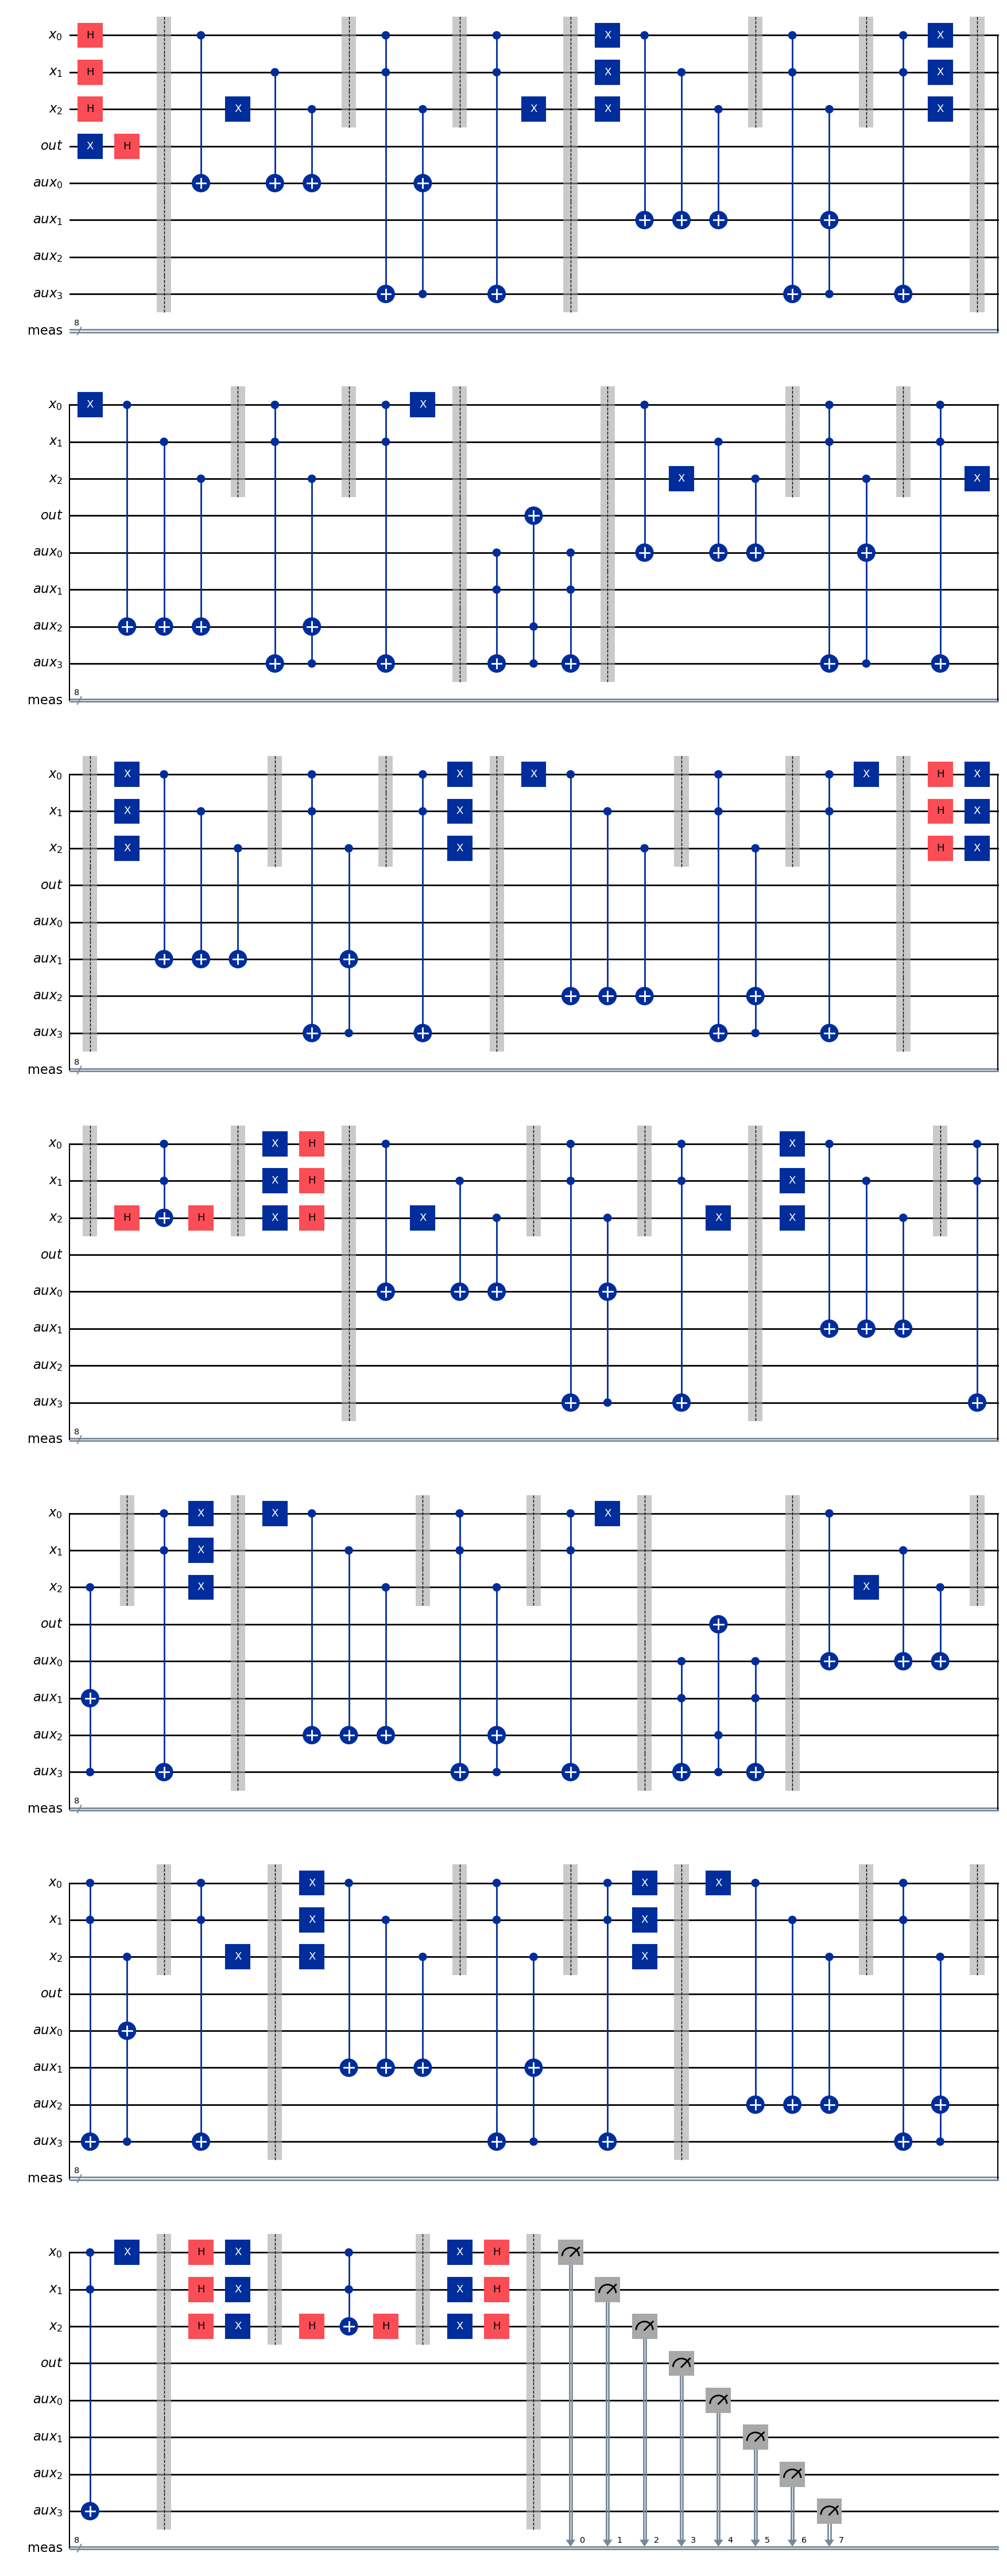

In [129]:
fig = grover.draw(output='mpl')

### Problem 2: Solving 1-IN-3-SAT

Given:

$$ F = (x_0 \vee \lnot x_1 \vee \lnot x_2) \wedge (\lnot x_0 \vee x_1 \vee \lnot x_2) \wedge (x_0 \vee x_1 \vee x_2) $$

First, use Grover's algorithm to solve the 1-IN-3-SAT problem for $F$, that is, find an assignment of $x_0$, $x_1$, and $x_2$ that will satisfy the expression $F$, given that only a single term in each expression can be true.

Try running the circuit using 1, 2 and 4 steps, and report the probabilities of all outcomes each time. How do the results change when you change the timesteps? Why do they change in that way?

[Your answer here]

### Problem 3: 6-bit Grover's Algorithm (for EE 521 only)

We define eight phone number $ p_1=000,p_1=001,p_3=010, ... p_{8}=111 $ and the names corresponding to the phone numbers are $ n_1=000,n_1=001,n_3=010, ... n_{8}=111 $ respectively. Recall that in Grover’s algorithm, the phone numbers are stored in three qubits and the name are stored in three other qubits. In terms of qubit states, the phone numbers are $ | p_1 \rangle =| 000\rangle, | p_2 \rangle=| 001\rangle, | p_3 \rangle=| 010\rangle, ... | p_{8} \rangle=| 111\rangle $ and the corresponding names stored on three other qubits are $ | p_1 \rangle =| 000\rangle, | p_2 \rangle=| 001\rangle, | p_3 \rangle=| 010\rangle, ... | p_{8} \rangle=| 111\rangle $. The phone numbers are identical to the names which are stored on three other qubits. Starting out with the state $ | 000000\rangle=| 000\rangle| 000\rangle, $  find the gate operations to reach the following states in the Grover’s algorithm sequentially:

(a) $ | init\rangle=\frac{1}{\sqrt{8}} [| 000\rangle| p_1 \rangle+| 001\rangle| p_2 \rangle+| 010\rangle| p_3 \rangle+ ... +| 111\rangle| p_{8} \rangle] $  
(b) $ \hat{V}| init\rangle=-\frac{1}{\sqrt{8}} | 110,p_7 \rangle + \frac{\sqrt{7}}{\sqrt{8}}[\frac{1}{\sqrt{7}} (| 000,p_1 \rangle+| 001,p_2 \rangle+| 010,p_3 \rangle + ...)] $  
(c) $ \hat{W}\hat{V}| init\rangle=\frac{5}{4\sqrt{2}}| 110\rangle| p_7 \rangle + \frac{\sqrt{7}}{4\sqrt{2}}[\frac{1}{\sqrt{7}} (| 000,p_1 \rangle+| 001,p_2 \rangle+| 010,p_3 \rangle + ...)]$  
(d) repeat above operations

Implement the above gates in qiskit and confirm that your realization is correct. What is the optimum number of rotations for this search problem in term of operations by $ \hat{W}\hat{V}$ ?


Hint: You can refer to Lecture note 7.5.2 section 


[Your answer here]

## Should we alert the press?

Quantum algorithms can provide an exponential speedup, compared to any known classical algorithm, for some problems. The problem we investigated here, 1-IN-3-SAT, is an $\mathcal{NP}$-complete problem, which means if we can efficiently solve it, then we can efficiently solve any $\mathcal{NP}$ problem (which includes a lot of very important, very interesting problems).

We don't know of any classical algorithm that can solve the 1-IN-3-SAT problem in faster than in exponential time ($\mathcal{O}(K^N)$) where $N$ is the number of variables.

Meanwhile, Grover's algorithm lets us search a space of size $N$ samples in on the order of $\mathcal{O}(\sqrt N)$ time. This means we can run Grover's algorithm in polynomial time (with respect to $N$).

This begs the question: Did we just find an algorithm that can solve an $\mathcal{NP}$-complete problem in polynomial time? If so, we have to alert the press right away - we just made history!!

### Problem 3: Fast, but is it fast enough?

Just what kind of speedup did applying Grover's algorithm give us (assuming we ran our circuit on a real quantum computer rather than just a simulator)? Did we find a polynomial time algorithm to solve 1-IN-3-SAT?

Hint: Remind yourself what the definitions of $N$ is for each of the running times above, how do they relate?

[Your answer here]